# Phân loại văn bản sử dụng Machine Learning

Chúng ta sẽ phân loại các đánh giá (tích cực, tiêu cực) về các bộ phim của người dùng. Đây là một ví dụ về phân loại nhị phân, một ứng dụng quan trọng của Machine Learning.

Chúng ta sẽ sử dụng tập dữ liệu IMDB, chứa 50.000 đánh giá từ trang web imdb.com. Tập này sẽ được chia ra làm 2 phần: 25.000 đánh giá sẽ được sử dụng làm tập Training và 25.000 đánh giá sẽ được sử dụng làm tập Testing. 

Ta sẽ dùng **tf.keras**, một API level cao để dựng và train mô hình trông TensorFlow.


In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.13.1


**Tải tập dữ liệu IMDB**

Tập dữ liệu IMDB được đóng gói sẵn trong TensorFlow. Nó cũng đã được tiền xử lý sao cho mỗi đánh giá đều được chuyển thành chuỗi các số, trong đó mỗi số đại diện cho 1 từ trong từ điển.

Lệnh sau tải về tập dữ liệu IMDB:

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


Biến **num_word** = 10.000 giữ lại 10.000 từ xuất hiện nhiều nhất trong tập Training. Những từ ít xuất hiện hơn sẽ được bỏ qua để đảm bảo kích cỡ dữ liệu có thể quản lý được.

**Phân tích dữ liệu**

Ta hãy bỏ chút thời gian để hiểu định dạng của dữ liệu trước khi bắt đầu. Tập dữ liệu đã được tiền xử lý: mỗi đánh giá là 1 mảng các số nguyên đại diện cho 1 từ. Mỗi nhãn sẽ có giá trị 0 hoặc 1, trong đó 0 nghĩa là đánh giá tiêu cực, 1 là tích cực.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


Dưới đây là đánh giá đầu tiên sau tiền xử lý:

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Tuy nhiên, mỗi đánh giá đều có độ dài khác nhau. Nhưng đầu vào của mạng neural về nguyên tắc phải có độ dài như nhau, nên chúng ta sẽ phải giải quyết vấn đề này sau.

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

**Chuyển đổi ngược từ số về chữ**

Chúng ta sẽ viết 1 hàm chuyển đổi từ các số nguyên về dạng chữ:

In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


Bây giờ chúng ta có thể gọi hàm **decode_review** để hiển thị đánh giá bất kỳ:

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

**Chuẩn bị dữ liệu**

Mỗi đánh giá - 1 mảng các số nguyên - cần phải chuyển đổi về chung định dạng trước khi cấp cho mạng neural. Có vài cách để làm việc này:

* Biến đổi các mảng về các vector của 0 và 1. Ví dụ, chuỗi [3, 5] sẽ cần biểu diễn thành vector 10.000 chiều, tất cả mang giá trị 0 ngoại từ chỉ số 3 và 5 mang giá trị 1. Sau đó, lớp đầu tiên trong mạng là lớp **Dense** có thể xử lý. Cách tiếp cận này không khả thi vì bộ nhớ cần lưu trữ ma trận có kích cỡ khổng lồ **num_words * num_reviews**.

* Thay vào đó, chúng ta có thể xử lý cho các mảng có cùng độ dài, sau đó tạo 1 tensor nguyên có kích cỡ **max_length * num_reviews**. Ta có thể dùng các lớp nhúng để xử lý giống như lớp đầu tiên trong mạng.

Chúng ta sẽ dùng cách tiếp cận thứ 2.

Vì các đánh giá phải có cùng chiều dài, ta sẽ dùng hàm **pad_sequences** để tiêu chuẩn hóa nó:

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Sau chuẩn hóa thì các đánh giá sẽ có độ dài như nhau:

In [10]:
len(train_data[0]), len(train_data[1])

(256, 256)

Nội dung đánh giá đầu tiên:

In [11]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

# Xây dựng mô hình

Mạng neural được xây dựng bằng cách xếp chồng các lớp với nhau, để làm được chúng ta phải trả lời được 2 câu hỏi:

* Mô hình cần dùng bao nhiêu lớp?

* Mỗi lớp cần dùng bao nhiêu đơn vị ẩn?

Nhắc lại 1 lần nữa, mỗi 1 đánh giá được biểu thị bằng 1 mảng các số nguyên. Mỗi nhãn mang giá trị 0 hoặc 1. Chúng ta sẽ xây dựng mô hình cho bài toán này:

In [12]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


Các lớp được xếp tuần tự để xây dựng mạng:

1. Lớp đầu tiên **Embedding**. Lớp này lấy các số nguyên đã được mã hóa và tra cứu vector nhúng cho mỗi chỉ mục của từ. Vector thêm 1 chiều cho mảng output. Chiều kết quả là: **(batch, sequence, embedding)**

2. Tiếp đó, một lớp **GlobalAveragePooling1D** trả về một vector output có độ dài cố định bằng cách lấy trung bình trên kích thước của chuỗi. Điều này cho phép mô hình xử lý input của độ dài biến bằng cách đơn giản nhất.

3. Vector output có độ dài cố định này được dẫn qua lớp **Dense** kết nối đầy đủ với 16 unit ẩn.

4. Lớp cuối cùng có kết nối dày đặc với 1 node đầu ra duy nhất. Bằng việc sử dụng hàm **sigmoid**, giá trị này sẽ là 1 số thực nằm trong khoảng 0 - 1, đại diện cho xác suất hay mức tự tin mà mô hình dự đoán.


**Các unit (đơn vị) ẩn**

Mô hình trên chứa 2 lớp trung gian (lớp ẩn), nằm giữa input và output. Số lượng output (unit, node, neural) là kích thước của không gian đại diện cho lớp. Hay nói cách khác, lượng mạng tự do là được cho phép khi học một đại diện nội bộ (??).

Nếu 1 mô hình có nhiều hơn các unit ẩn (1 chiều cao hơn không gian đại diện), thì mạng có thể học nhiều đại diện phức tạp hơn. Tuy nhiên, điều này lại khiến mạng tốn nhiều tài nguyên hơn để train và có thể dẫn tới mô hình không mong muốn - một mô hình chỉ cải thiện trên dữ liệu training nhưng không cải thiện trên dữ liệu Testing. Điều này được gọi là overfitting, và chúng ta sẽ khám phá nó sau.

**Loss Function (hàm mất mát) và Optomizer (tối ưu)**

Một mô hình cần tới Loss Function và Opitimizer để training. Vì đây là bài toán phân loại nhị phân và output là 1 giá trị xác suất, chúng ta sẽ sử dụng hàm mất mát **binary_crossentropy**.

Tuy nhiên đây không phải là sự lựa chọn duy nhất cho 1 hàm mất mát. Nhưng thông thường, **binary_crossentropy** sẽ xử lý tốt hơn các giá trị xác suất. Nó sẽ tính toán sai khác giữa các phân bố của các giá trị xác suất, trong trường hợp này, là sự sai khác giữa phân phối thật và dự đoán.

Bây gờ, cấu hình mạng để sử dụng Loss Function và Optimizer:



In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

#Tạo 1 bộ xác nhận

Khi training, chúng ta muốn kiếm tra độ chính xac của mô hình trên dữ liệu mà chúng ta chưa có. Tạo 1 bộ xác nhận bằng cách tách 10.000 ví dụ từ dữ liệu ban đầu. (Tại sao lại không sử dụng bộ Testing bây giờ? Mục tiêu của chúng ta là tạo và điều chỉnh mô hình chỉ sử dụng tập Training, sau đó chỉ sử dụng tập Testing 1 lần để kiểm tra độ chính xác mà thôi).

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#Train mô hình

Train mô hình 40 kỳ trong các lô nhỏ gồm 512 mẫu. Đây là 40 lần lặp trên tất cả các mẫu trong tensor **x_train** và **y_train**. Khi train, ta theo dõi mất mát của mô hình và độ chính xác trên 10.000 mẫu từ tập xác nhận ở trên:

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 69us/sample - loss: 0.6921 - acc: 0.5421 - val_loss: 0.6905 - val_acc: 0.5979
Epoch 2/40
15000/15000 [==============================] - 1s 51us/sample - loss: 0.6865 - acc: 0.6921 - val_loss: 0.6818 - val_acc: 0.6882
Epoch 3/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.6724 - acc: 0.7405 - val_loss: 0.6641 - val_acc: 0.7563
Epoch 4/40
15000/15000 [==============================] - 1s 51us/sample - loss: 0.6484 - acc: 0.7573 - val_loss: 0.6370 - val_acc: 0.7657
Epoch 5/40
15000/15000 [==============================] - 1s 52us/sample - loss: 0.6138 - acc: 0.7913 - val_loss: 0.6014 - val_acc: 0.7871
Epoch 6/40
15000/15000 [==============================] - 1s 51us/sample - loss: 0.5711 - acc: 0.8128 - val_loss: 0.5608 - val_acc: 0.8041
Epoch 7/40
15000/15000 [==============================] - 1s 50us/sa

#Đánh giá mô hình

Chúng ta hãy cùng xem mô hình hoạt động. Bằng cách trả về 2 giá trị mất mát và độ chính xác:

In [17]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 36us/sample - loss: 0.3302 - acc: 0.8720
[0.330184359998703, 0.872]


Cách tiếp cận căn bản này đạt được độ chính xác tới 87%. Với những cách tiếp cận nâng cao hơn, mô hình có thể đạt tới độ chính xác ấn tượng: 95%.


#Vẽ biểu đồ về độ chính xác và mất mát

hàm **model.fit()** trả về một đối tượng **History** chứa từ điển cùng mọi thứ xảy ra trong quá trình train:

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Có 4 mục: mỗi số liệu được theo dõi trong quá trình train và đánh giá tập xác nhận. Chúng ta có thể sử dụng nó để vẽ biểu đồ so sánh giữa mất mát và độ chính xác của tập Training và tập xác nhận.

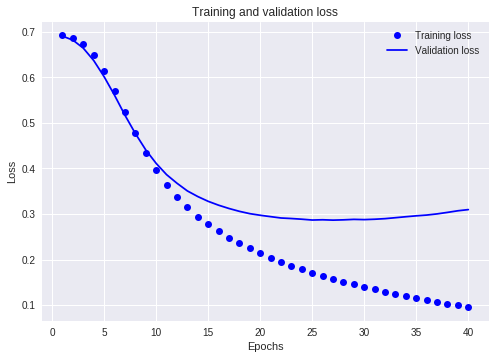

In [19]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
<Figure size 640x480 with 1 Axes>

SyntaxError: ignored

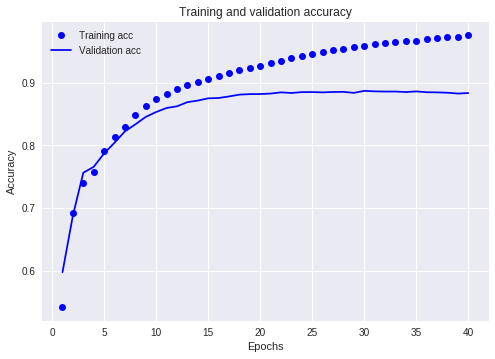

In [21]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Trong biểu đồ này, các điểm biểu diễn mất mát và độ chính xác của tập Trainning, và đường xanh là của tập xác nhận.

Nhận thấy mất mát Training giảm giần và tính chính xác tăng dần theo từng kỳ.

Với tập xác thực, mất mát và độ chính xác gần như đạt đỉnh sau khoảng 20 kỳ. Đây là ví dụ của overfitting - khi mà mô hình hoạt động tốt hơn trong tập Training so với tập dữ liệu mới hoàn toàn. Sau thời điểm này, mô hình trở nên tối ưu hóa quá mức và học từng đặc điểm riêng biệt của dữ liệu Training và không thể khái quát cho dữ liệu Testing (??).